In [1]:
import numpy as np

from detectors.ghostbuster.ngrams import UnigramModel, TrigramModel
from datasets import load_dataset

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
xlsum = load_dataset('anakib1/mango-truth', 'xlsum')

In [3]:
length_match = xlsum['train'].filter(lambda x: len(x['output']) < 1750)
reference = length_match.filter(lambda x: x['label'] == 0).take(1000)
generated = length_match.filter(lambda x: x['label'] == 3)

X = reference['output'] + generated['output']
y = [0] * len(reference) + [1] * len(generated)

In [4]:
unigram = UnigramModel(tokenizer_handle='BEE-spoke-data/cl100k_base-mlm')
unigram.train(X)

trigram = TrigramModel(tokenizer_handle='BEE-spoke-data/cl100k_base-mlm')
trigram.train(X)

In [5]:
from detectors.ghostbuster.openai import OpenaiProbabilityEstimator
from dotenv import load_dotenv

load_dotenv()

estimator = OpenaiProbabilityEstimator(model_name='babbage-002')

In [7]:
from detectors.ghostbuster.features import extract_features
from tqdm.auto import tqdm
import pickle, os

models = [unigram, trigram, estimator]

feats = []

if os.path.exists('./feats.pkl'):
    with open('./feats.pkl', 'rb') as f:
        feats = pickle.load(f)

In [10]:
for i in tqdm(range(len(feats), len(X))):
    x = X[i]
    feats.append(extract_features([model.get_text_log_proba(x)[1] for model in models]))

  0%|          | 0/3900 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
import pickle

with open('feats.pkl', 'wb') as f:
    pickle.dump(feats, f)

In [10]:
feats = np.stack(feats)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

model = make_pipeline(StandardScaler(), CalibratedClassifierCV(LogisticRegression(C=1, max_iter=1000)))
model.fit(feats, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('calibratedclassifiercv',
                 CalibratedClassifierCV(estimator=LogisticRegression(C=1,
                                                                     max_iter=1000)))])

In [14]:
y_test_hat = model.predict_proba(feats)
y_test = y

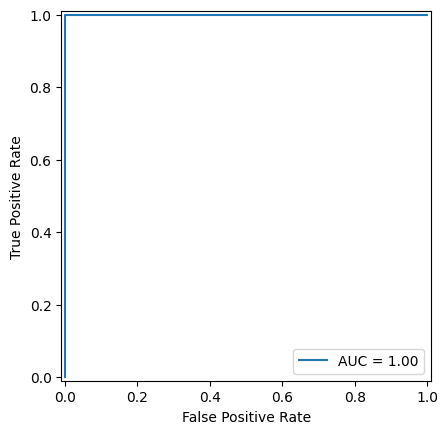

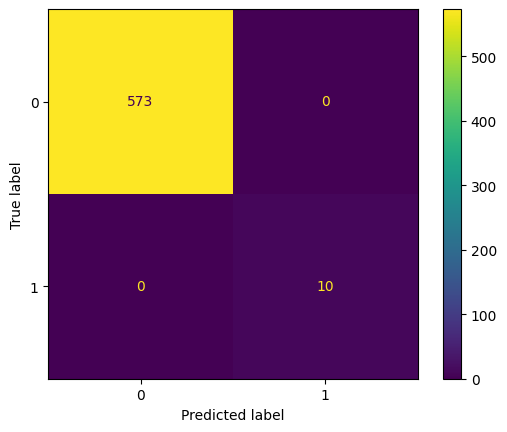

In [16]:
from detectors.neptune.nexus import NeptuneNexus
from detectors.utils.training import calculate_classification
from uuid import uuid4


test = calculate_classification(y_test, y_test_hat[:, 1])

In [17]:
from detectors.ghostbuster.model import GhostbusterDetector

estimator = GhostbusterDetector(model, models)

In [19]:
from detectors.metrics import Conclusion

conclusion = Conclusion(
    weights=estimator.store_weights(),
    detector_handle='ghostbuster',
    datasets=['xlsum'],
    train_conclusion=test,
    validation_conclusion=test
)

In [22]:
training_nexus = NeptuneNexus()

training_nexus.conclude_run(uuid4(), conclusion=conclusion, extra_data={"info" : 'DEBUG'})

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/mango/mango-truth/
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/mango/mango-truth/e/MNGTRTH-22
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/mango/mango-truth/e/MNGTRTH-22


In [24]:
from uuid import UUID

obj = GhostbusterDetector()

obj.load_weights(training_nexus.load_run_weights(UUID('b2a625f2-724f-49eb-b54b-6250b6d1e436')))

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/mango/mango-truth/e/MNGTRTH-22


Fetching file...: 0 [00:00, ?/s]

Exception: ('Error occurred while loading weights.', Exception("Object's type don't match. Expected <class 'sklearn.linear_model._logistic.LogisticRegressionCV'>, but got <class 'sklearn.pipeline.Pipeline'>"))